# Comparison between classical and quantum running times for MNIST experiment

### Setup

In [9]:
import os
os.chdir("../../quantum_eigenfaces/package/")
import IPython

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
import glob
import re
import csv 

from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from quantum_eigenfaces.epsilon_tuning import epsilon_tuning 
from quantum_eigenfaces.utils.utils import DataSplit, TrainingConfig, TuningConfig



### Load MNIST Dataset

In [12]:
import joblib
memory_mnist = joblib.Memory('./tmp_mnist')
fetch_openml_cached_mnist = memory_mnist.cache(fetch_openml)

X, y = fetch_openml_cached_mnist('mnist_784', version=1, return_X_y=True)  

n_labels = len(set(y))

train_val_test = [0.70,0.15,0.15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)

tot = len(X_train) + len(X_val) + len(X_test) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train)/tot}")
print(f"Validation set: {len(X_val)/tot}")
print(f"Test set: {len(X_test)/tot}")


X_train = X_train.to_numpy()
X_valid = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().astype(int)
y_valid = y_val.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)



Datapoints number: 70000
Classes number: 10
Training set: 0.7
Validation set: 0.15
Test set: 0.15


### Load Outliers: Fashion MNIST

In [13]:
import joblib
memory = joblib.Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)

X, y = fetch_openml_cached(data_id=40996, return_X_y=True) # Fashion MNIST

n_labels = len(set(y))

train_val_test = [0.70,0.05,0.05]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)


tot = len(X_train2) + len(X_val2) + len(X_test2) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train2)/tot}")
print(f"Validation set: {len(X_val2)/tot}")
print(f"Test set: {len(X_test2)/tot}")


Datapoints number: 70000
Classes number: 10
Training set: 0.8999857142857143
Validation set: 0.05001428571428571
Test set: 0.05


### Combine datasets

In [15]:

X_valid_wa = np.concatenate([X_valid, X_val2.to_numpy()])
y_valid_wa = np.concatenate([[int(y) for y in y_valid], [-1 for _ in range(len(X_val2))]])
X_test_wa = np.concatenate([X_test, X_test2.to_numpy()])
y_test_wa = np.concatenate([[int(y) for y in y_test], [-1 for _ in range(len(X_test2))]])



### Normalization

In [16]:
X_train_n = X_train / 255
X_valid_n = X_valid / 255
X_valid_wa_n = X_valid_wa / 255
X_test_n = X_test / 255
X_test_wa_n = X_test_wa / 255

In [17]:
print(f"X_train_n:    {X_train.shape}")
print(f"y_train:      {y_train.shape}")
print("------------------------")
print(f"X_valid_n:    {X_valid.shape}")
print(f"y_valid:      {y_valid.shape}")
print(f"X_valid_wa_n: {X_valid_wa.shape}")
print(f"y_valid_wa:   {y_valid_wa.shape}")
print("------------------------")
print(f"X_test_n:     {X_test.shape}")
print(f"y_test:       {y_test.shape}")
print(f"X_test_wa_n:  {X_test_wa.shape}")
print(f"y_test_wa:    {y_test_wa.shape}")

X_train_n:    (49000, 784)
y_train:      (49000,)
------------------------
X_valid_n:    (10500, 784)
y_valid:      (10500,)
X_valid_wa_n: (14001, 784)
y_valid_wa:   (14001,)
------------------------
X_test_n:     (10500, 784)
y_test:       (10500,)
X_test_wa_n:  (14000, 784)
y_test_wa:    (14000,)


### Formalize dataset splits and fitting configurations

In [18]:

datasplit_without_outliers = DataSplit(X_train=X_train_n, 
                                        y_train=y_train, 
                                        X_valid=X_valid_n, 
                                        y_valid=y_valid, 
                                        X_test=X_test_n, 
                                        y_test=y_test)

datasplit_with_outliers = DataSplit(X_train=X_train_n, 
                                    y_train=y_train, 
                                    X_valid=X_valid_wa_n, 
                                    y_valid=y_valid_wa, 
                                    X_test=X_test_wa_n, 
                                    y_test=y_test_wa)

training_config = TrainingConfig(n_components=60)
tuning_config = TuningConfig(tot_num_of_deltas=1600)



## Fit model

In [19]:
from quantum_eigenfaces.quantum_model import QuantumModel
qm = QuantumModel(X_train=X_train_n,
                  y_train=y_train,
                  X_valid=X_valid_n,
                  y_valid=y_valid,
                  X_test=X_test_n,
                  y_test=y_test,
                  reshaper=(28,28))

qm.fit(n_components=60, delta1=22.339989)


********* TRAINING **************
Normalization Threshold is: 0.74854
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.


In [20]:
epsilons = range(0, 90, 5)
qruntimes = []
cruntimes = []

for epsilon in epsilons:
    print("********")
    print("Epsilon: ", epsilon)
    qrt, crt = qm.runtime(epsilon=epsilon, num_components=60, verbose=False)
    qrt = np.mean(qrt)
    qruntimes.append(qrt)
    cruntimes.append(crt)
    
rts = pd.DataFrame({"epsilon": epsilons, "classical runtime": cruntimes, "average runtime": qruntimes})


********
Epsilon:  0
********
Epsilon:  5
sqrt p: 221.35943621178654
mu: 7.229457777240143
max_c_train_norm: 11.594529325737465
avg U_bar_norms: 7.179237349285472
epsilon: 5
********
Epsilon:  10
sqrt p: 221.35943621178654
mu: 7.229457777240143
max_c_train_norm: 11.594529325737465
avg U_bar_norms: 7.179237349285472
epsilon: 10
********
Epsilon:  15
sqrt p: 221.35943621178654
mu: 7.229457777240143
max_c_train_norm: 11.594529325737465
avg U_bar_norms: 7.179237349285472
epsilon: 15
********
Epsilon:  20
sqrt p: 221.35943621178654
mu: 7.229457777240143
max_c_train_norm: 11.594529325737465
avg U_bar_norms: 7.179237349285472
epsilon: 20
********
Epsilon:  25
sqrt p: 221.35943621178654
mu: 7.229457777240143
max_c_train_norm: 11.594529325737465
avg U_bar_norms: 7.179237349285472
epsilon: 25
********
Epsilon:  30
sqrt p: 221.35943621178654
mu: 7.229457777240143
max_c_train_norm: 11.594529325737465
avg U_bar_norms: 7.179237349285472
epsilon: 30
********
Epsilon:  35
sqrt p: 221.35943621178654
mu

In [26]:
rts.loc[0, "average runtime"] = np.nan
rts

,epsilon,classical runtime,average runtime
0,0,2987040,NaN
1,5,2987040,26641.900146
2,10,2987040,13320.950073
3,15,2987040,8880.633382
4,20,2987040,6660.475037
5,25,2987040,5328.380029
6,30,2987040,4440.316691
7,35,2987040,3805.985735
8,40,2987040,3330.237518
9,45,2987040,2960.211127


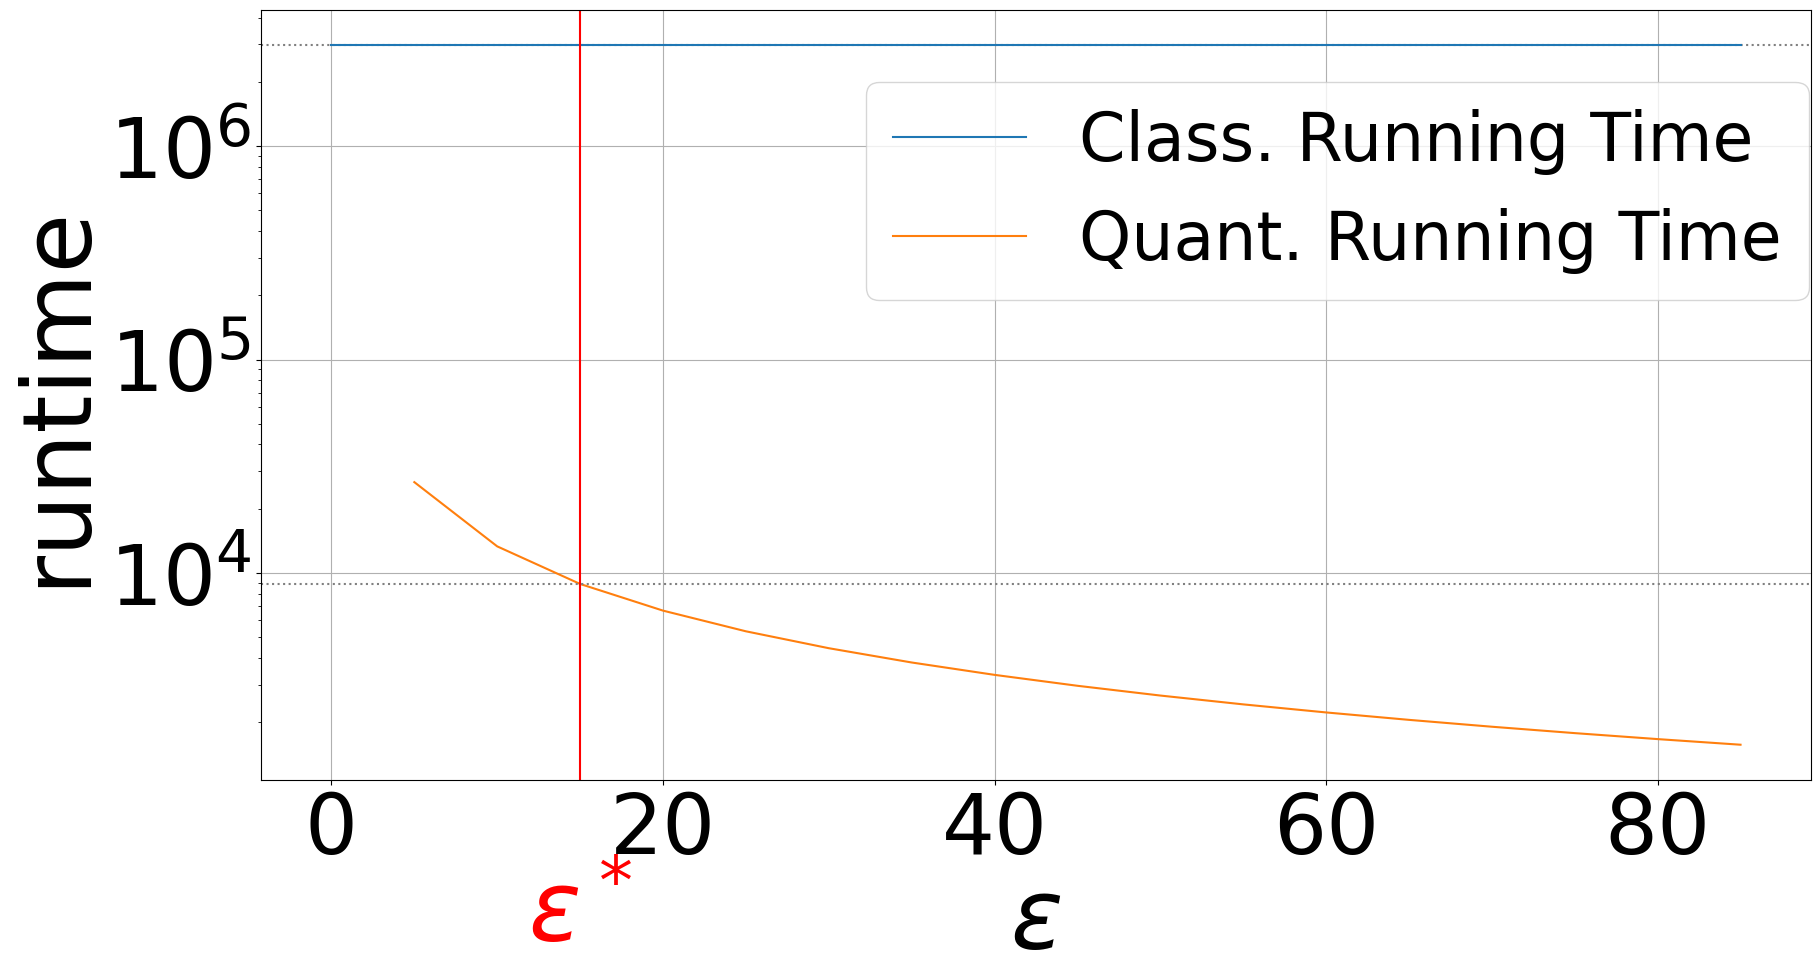

In [34]:
import matplotlib

def plot_quantum_vs_classical(rts, highest_acceptable_epsilon):
    plt.figure(figsize=(20, 10))

    fontsize = 60
    legend_fontsize = 48
    
    matplotlib.rcParams.update({'font.size': fontsize})

    x_padding = -16
    
    # Classical runtime
    crt = rts["classical runtime"].values[0]
    plt.axhline(crt, linestyle=":", c="grey")
    #plt.text(x_padding, crt, "$2.99 \cdot 10^6$", ha='center', va='center', c="grey", fontsize=fontsize - 3)
    plt.plot(rts["epsilon"], rts["classical runtime"], label="Class. Running Time")
    
    # Quantum runtime
    plt.plot(rts["epsilon"], rts["average runtime"], label="Quant. Running Time")
    plt.xlabel("$\epsilon$", fontsize=fontsize + 10)
    plt.ylabel("runtime", fontsize=fontsize + 10)

    
    plt.yscale('log')

    plt.axvline(x=highest_acceptable_epsilon, c="red")

    plt.text(highest_acceptable_epsilon, 250, r'$\epsilon^*$', ha='center', va='center', c="red", fontsize=fontsize + 10)
    
    y = rts[rts["epsilon"] == highest_acceptable_epsilon]["average runtime"].values[0]
    plt.axhline(y, linestyle=":", c="grey")

    plt.grid(True)
    plt.legend(fontsize=legend_fontsize, loc="upper right", bbox_to_anchor=(1.02, 0.95))
    
    plt.xticks(rts["epsilon"].values[0:-1:4])
    plt.savefig("MNIST_quantum_runtime.pdf", bbox_inches='tight')
    
plot_quantum_vs_classical(rts=rts[0:], highest_acceptable_epsilon=15)

### $\delta_1= tuned$;  Norm Threshold = True; Anomalies = True

In [ ]:
epsilons_domain = np.arange(0, 200, 20) # [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
summary4, rts4 = epsilon_tuning(datasplit=datasplit_with_anomalies, 
                                training_config=training_config, 
                                tuning_config=tuning_config,
                                reshaper=(28,28),
                                epsilons=epsilons_domain,
                                use_norm_threshold=True,
                                num_iterations=10,
                                delta1=22.084108,
                                ds_name="MNIST",
                                compute_runtimes=True)


In [ ]:
summary4.head()

In [ ]:
def find_highest_acceptable_epsilon(summary):
    starting_accuracy = summary.loc[0, "Accuracy"]
    print(starting_accuracy)
    accuracy_threshold = starting_accuracy * 0.975
    print(accuracy_threshold)
    highest_acceptable_epsilon = summary["epsilon"][summary["Accuracy"] >= accuracy_threshold][-1:].values[0]
    return highest_acceptable_epsilon

highest_acceptable_epsilon = find_highest_acceptable_epsilon(summary4)
highest_acceptable_epsilon

In [ ]:
from quantum_eigenfaces.utils.visualization import plot_metrics_at_varying_epsilon
plot_metrics_at_varying_epsilon(summary4, "MNIST", epsilon_domain=epsilons_domain)